In [ ]:
#Importing Libraries

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import time

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Getting Images

X = []
for imagename in os.listdir('drive/MyDrive/Colab Notebooks/Colorization/sk8Data-256-160'):
    X.append(
        img_to_array(
            load_img('drive/MyDrive/Colab Notebooks/Colorization/sk8Data-256-160/' + imagename)))
X = np.array(X, dtype=float)


# Set up train and test data
# train number : test number = 4 : 1
split = int(0.8*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [ ]:
#CNN model

from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential

model = Sequential()

# Input Layer
# Input size: 160 * 256
model.add(Conv2D(64, (3, 3), input_shape=(160, 256, 1), activation='relu', padding='same'))

#Hidden Layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

#Compiling the CNN
model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

In [ ]:
import matplotlib.pyplot as plt

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 20
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model      
tensorboard = TensorBoard(log_dir="/output/beta_run")
# epoches: 500, steps per epoch: 30
trainedmodel = model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard],epochs=500, steps_per_epoch=30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/500
30/30 [==============================] - 21s 280ms/step - loss: 0.1766 - accuracy: 0.6456
Epoch 2/500
30/30 [==============================] - 8s 282ms/step - loss: 0.0258 - accuracy: 0.6547
Epoch 3/500
30/30 [==============================] - 9s 286ms/step - loss: 0.0257 - accuracy: 0.6693
Epoch 4/500
30/30 [==============================] - 8s 283ms/step - loss: 0.0247 - accuracy: 0.6483
Epoch 5/500
30/30 [==============================] - 8s 278ms/step - loss: 0.0264 - accuracy: 0.6563
Epoch 6/500
30/30 [==============================] - 8s 279ms/step - loss: 0.0228 - accuracy: 0.6399
Epoch 7/500
30/30 [==============================] - 8s 282ms/step - loss: 0.0261 - accuracy: 0.6612
Epoch 8/500
30/30 [==============================] - 9s 286ms/step - loss: 0.0249 - accuracy: 0.6437
Epoch 9/500
30/30 [==============================] - 10s 340ms/step - loss: 0.0260 - accuracy: 0.6613
Epoch 10/500
30/30 [==============================] - 8s 283ms/step - loss: 0.0255 - accu

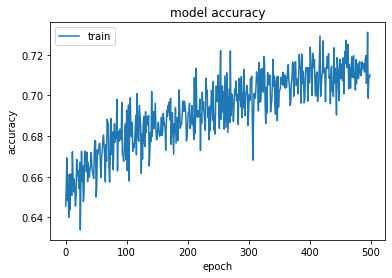

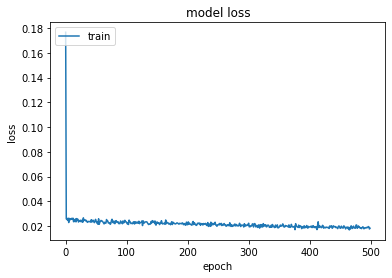

In [ ]:
# summarize history for accuracy
plt.plot(trainedmodel.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save model

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [19]:
# load json and create model

from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [22]:
loaded_model.summary()

# Test images
# Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
# Xtest = Xtest.reshape(Xtest.shape+(1,))
# Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
# Ytest = Ytest / 128
# print(loaded_model.evaluate(Xtest, Ytest, batch_size=32))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 128, 64)       36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 128, 128)      73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 64, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 64, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 32, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 32, 512)       1

In [ ]:
# Manual Testing of Images

import cv2
import os
%matplotlib inline 
from matplotlib import pyplot as plt

fig, ax = plt.subplots(17, 2, figsize=(16,100))
row = 0
colorize = []
print('Output of the Model')
for filename in os.listdir('drive/MyDrive/Colab Notebooks/Colorization/test-cnn'):
	colorize.append(img_to_array(load_img('drive/MyDrive/Colab Notebooks/Colorization/test-cnn/'+filename)))
	ax[row,0].imshow(load_img('drive/MyDrive/Colab Notebooks/Colorization/test-cnn/'+filename), interpolation='nearest')
	row +=1

colorize = np.array(colorize, dtype=float)
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))


# Test model
output = loaded_model.predict(colorize)
output = output * 128

row = 0

# Output colorizations
for i in range(len(output)):
	cur = np.zeros((160, 256, 3))
	cur[:,:,0] = colorize[i][:,:,0]
	cur[:,:,1:] = output[i]
	resImage = lab2rgb(cur)
	ax[row,1].imshow(resImage, interpolation='nearest')
	row +=1
	imsave(f"drive/MyDrive/Colab Notebooks/Colorization/result/cnn/img_+{time.time()}+.png", resImage)
 

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Manual Testing of Images

import cv2
import os
%matplotlib inline 
from matplotlib import pyplot as plt

fig, ax = plt.subplots(25, 2, figsize=(16,200))
row = 0
colorize = []
print('Output of the Model')
for filename in os.listdir('drive/MyDrive/Colab Notebooks/Colorization/test-cnn-trained'):
	colorize.append(img_to_array(load_img('drive/MyDrive/Colab Notebooks/Colorization/test-cnn-trained/'+filename)))
	ax[row,0].imshow(load_img('drive/MyDrive/Colab Notebooks/Colorization/test-cnn-trained/'+filename), interpolation='nearest')
	row +=1

colorize = np.array(colorize, dtype=float)
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))


# Test model
output = loaded_model.predict(colorize)
output = output * 128

row = 0

# Output colorizations
for i in range(len(output)):
	cur = np.zeros((160, 256, 3))
	cur[:,:,0] = colorize[i][:,:,0]
	cur[:,:,1:] = output[i]
	resImage = lab2rgb(cur)
	ax[row,1].imshow(resImage, interpolation='nearest')
	row +=1
	imsave(f"drive/MyDrive/Colab Notebooks/Colorization/result/cnn/img_+{time.time()}+.png", resImage)

Output hidden; open in https://colab.research.google.com to view.